In [1]:
ls ~/Dropbox/data/gta

 gohMinimapController/   senoraFreeway/
 justDeserts/           'sign of things to come'/
 obs/                   'sign of things to come -- with taskbar'/
'on the GOH'/            taking_off/
 pygta2sandyshores/


In [3]:
import numpy as np

import matplotlib.pyplot as plt

try:
    from PIL import Image
except ImportError:
    import Image
import pytesseract

from tqdm.auto import tqdm
from PIL import ImageEnhance
import PIL.Image
from pytesseract import image_to_string

In [10]:
from os.path import join, expanduser

In [147]:
data_path = join(expanduser('~'), 'data', 'gta', 'highway_2021_08-a.npz')

In [148]:
data = np.load(data_path, allow_pickle=True)

In [17]:
list(data.keys())

['dtype', 'X', 'Y']

In [18]:
data['dtype']

array(<class 'object'>, dtype=object)

In [19]:
X = data['X']
Y = data['Y']

In [21]:
X.shape

(557, 2)

In [31]:
X1, X2 = X.T

In [45]:
# X1.shape, X1[:4]
image_times = X1.astype('float')

In [46]:
dts = np.diff(image_times)[:10]
np.mean(dts), np.std(dts)

(0.16082465648651123, 0.010477207238644388)

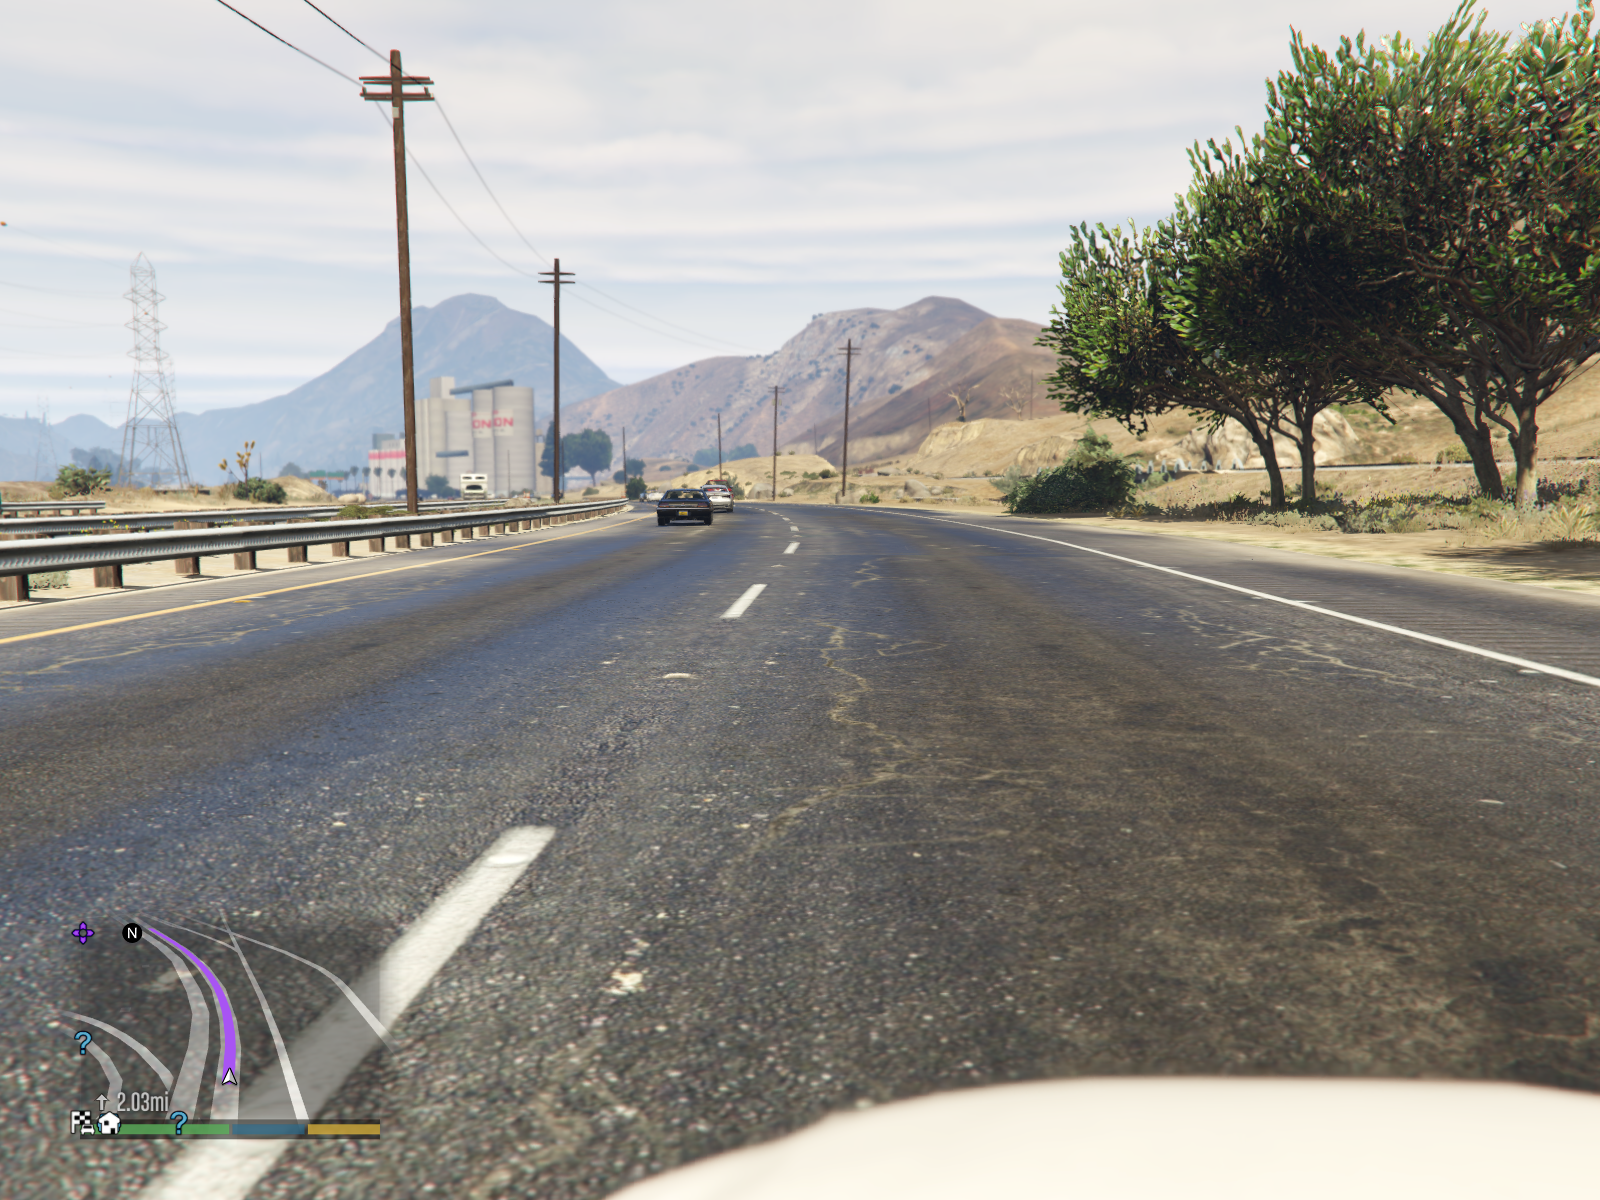

In [80]:
# X2.shape, X2[:4]
images = np.stack(X2).astype('uint8')
Image.fromarray(images[0])

In [204]:
def get_miles_subimage(im):
    subarr = im[1085:1115, 110:180].astype('float')
#     subarr -= 40
#     subarr /= 160
    
#     subarr = np.linalg.norm(subarr, axis=2)
# #     subarr[subarr>1] = 1
# #     subarr[subarr<0] = 0
#     subarr[subarr < 260] = 0
#     subarr[subarr > 255] = 255
# #     subarr *= 255
    
    return subarr.astype('uint8')

Image.fromarray(get_miles_subimage(images[0]))

In [205]:
oem_dat = '''  0    Legacy engine only.
  1    Neural nets LSTM engine only.
  2    Legacy + LSTM engines.
  3    Default, based on what is available.
'''
psm_dat = '''  0    Orientation and script detection (OSD) only.
  1    Automatic page segmentation with OSD.
  2    Automatic page segmentation, but no OSD, or OCR.
  3    Fully automatic page segmentation, but no OSD. (Default)
  4    Assume a single column of text of variable sizes.
  5    Assume a single uniform block of vertically aligned text.
  6    Assume a single uniform block of text.
  7    Treat the image as a single text line.
  8    Treat the image as a single word.
  9    Treat the image as a single word in a circle.
 10    Treat the image as a single character.
 11    Sparse text. Find as much text as possible in no particular order.
 12    Sparse text with OSD.
 13    Raw line. Treat the image as a single text line'''
def dat_2_dict(dat):
    lines = [l.strip() for l in dat.split('\n') if len(l.strip())]
    ids = [int(l.split()[0]) for l in lines]
    descs = [' '.join(l.split()[1:]) for l in lines]
    return {i: d for (i, d) in zip(ids, descs)}
oems = dat_2_dict(oem_dat)
psms = dat_2_dict(psm_dat)

Got text: "1.46mi -" 
-> "1.46mi "


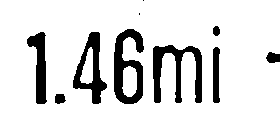

In [256]:
def mode(a, bins=32):
    counts, bins = np.histogram(a.ravel(), bins=bins)
    centers = bins[:-1] + np.diff(bins) / 2.
    return centers[np.argmax(counts)]
    
def smooth(y, box_pts):
    box = np.ones(box_pts)/box_pts
    y_smooth = np.convolve(y, box, mode='same')
    return y_smooth

def boost_contrast(img, factor):
    enhancer = ImageEnhance.Contrast(img)
    return enhancer.enhance(factor)

def sharpen(img, factor):
    enhancer = ImageEnhance.Sharpness(img)
    return enhancer.enhance(factor)

def sanitize(s, a=True, A=True, n=True, extra=' ', replace=''):
    allowed = extra
    alpha = 'abcdefghijklmnopqrstuvwxyz'
    if a:
        allowed += alpha
    if A:
        allowed += alpha.upper()
    if n:
        allowed += '1234567890'
    return ''.join([
        (c if c in allowed else replace)
        for c in s
    ])

def enhance(img, upscale=4, grey=True, contrast_factor=1.2, 
            sharpness_factor=1, otsu=False, array=True, 
            binarize_level=170, flip=True):
    if isinstance(img, np.ndarray):
        img = PIL.Image.fromarray(img)

    # Do operations on PIL Image.
    if upscale > 1:
        new_size = tuple(upscale*x for x in img.size)
        img = img.resize(new_size, PIL.Image.ANTIALIAS)
    if contrast_factor != 1:
        img = boost_contrast(img, contrast_factor)
    if sharpness_factor != 1:
        img = sharpen(img, sharpness_factor)
    if grey:
        img = img.convert('L')

    # Do operations on ndarray.
    if otsu:
        from skimage import filters
        img = np.array(img)
        val = filters.threshold_otsu(img)
        img = (img < val).astype('uint8') * 255

    img = np.asarray(img)
    if len(img.shape) == 2:
        img = np.stack([img, img, img], -1)

    if binarize_level:
        img[img < binarize_level] = 0
        img[img >= binarize_level] = 255
        
    if flip:
        img = (255 - img.astype(int)).astype('uint8')
        
    # Maybe return PIL Image.
    if array:
        return img
    else:
        return PIL.Image.fromarray(img)

def get_text(img, 
    ascii=True, 
    dictionary=False, whitelist=None, OCR_engine_mode=1, page_segmentation_mode=12,
    std_threshold=7,
    **enhance_kw
    ):
    enhanced_img = enhance(img, **enhance_kw)

    # Short-circuit if the image is very smooth.
    stdkw = {}
    stdkw.update(enhance_kw)
    stdkw['sharpness_factor'] = 0
    std = enhance(img, **stdkw, array=True).std()
    if std < std_threshold:
        return ''

    # Generate Tesseract config options
    # see https://github.com/tesseract-ocr/tesseract/wiki/Command-Line-Usage
    config = '--oem %d --psm %d' % (OCR_engine_mode, page_segmentation_mode)
    if not dictionary:
        config = '%s -c load_system_dawg=0 -c load_freq_dawg=0' % config
    if whitelist is not None:
        config = '%s -c tessedit_char_whitelist=%s' % (config, whitelist)
        
#     print('config:', config)
#     print('oem=', oems[OCR_engine_mode])
#     print('psm=', psms[page_segmentation_mode])

    out = image_to_string(enhanced_img, config=config)

    if ascii:
        out = out.encode('ascii', errors='ignore').decode('ascii')

    return out, enhanced_img

t, im = get_text(get_miles_subimage(images[-1]))
ts = sanitize(t, extra=' .')
print('Got text: "{text}" \n-> "{sanitized}"'.format(text=t.strip(), sanitized=ts))
Image.fromarray(im)

Got text: "2.03mi *" 
-> "2.03mi "


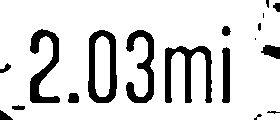

In [257]:
t, im = get_text(get_miles_subimage(images[0]))
ts = sanitize(t, extra=' .')
print('Got text: "{text}" \n-> "{sanitized}"'.format(text=t.strip(), sanitized=ts))
Image.fromarray(im)

Got text: "1.93mi" 
-> "1.93mi"


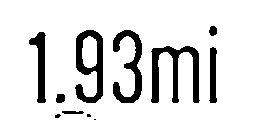

In [258]:
t, im = get_text(get_miles_subimage(images[100]))
ts = sanitize(t, extra=' .')
print('Got text: "{text}" \n-> "{sanitized}"'.format(text=t.strip(), sanitized=ts))
Image.fromarray(im)

In [289]:
def get_dist(im):
    t, im = get_text(get_miles_subimage(im))
    ts = sanitize(t, extra='.')
    n = sanitize(t, a=False, A=False, extra='.')
    
    # Ignore periods after the first one.
    period_tokens = n.split('.')
    n = '.'.join(period_tokens[:2])
    if len(period_tokens) > 2:
        n = n + ''.join(period_tokens[2:])
        
    unit = 'mi' if 'm' in ts else ('ft' if 'f' in ts else '?')
    
    n = '' if n == '.' else n  # Give up if we just see a period.
    
    d = None if not n else float(n)
    return d, unit

In [292]:
get_dist(images[554])

(None, 'mi')

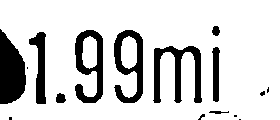

In [293]:
Image.fromarray(enhance(get_miles_subimage(images[43])))

In [294]:
dists_units = []
for im in tqdm(images, unit='images'):
    dists_units.append(get_dist(im))

In [306]:
dists_any_units = np.array([d for (d,u) in dists_units]).astype(float)
dists_any_units[dists_any_units > 10.0] = np.nan

/home/tsbertalan/.virtualenvs/tfcpu/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in greater
  


In [307]:
units = [u for (d,u) in dists_units]

In [329]:
dists_miles = np.array([
    d if u == 'mi' else float(d) / 5280.
    for (d,u) in zip(dists_any_units, units)
])

In [330]:
ok = np.argwhere(np.logical_not(np.isnan(dists_miles))).ravel()

Text(0.5, 0, 'Time [s]')

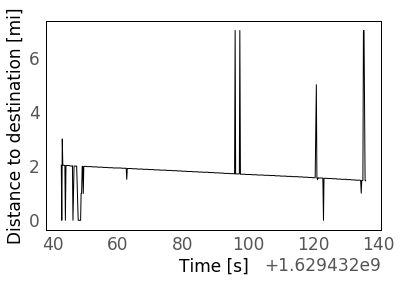

In [396]:
fig, ax = plt.subplots()
absc = image_times[ok]
ordi = dists_miles[ok]
from scipy.stats import mode
modal_tenth = lambda arr: float(mode((arr*10).astype(int)).mode) * 0.1
a = modal_tenth(ordi[-10:])
b = modal_tenth(ordi[:10])
d = abs(a - b)
lo = min(a, b) - .1 * d
hi = max(a, b) + .1 * d
ax.plot(absc, ordi)
# ax.set_ylim(lo, hi)
ax.set_ylabel('Distance to destination [mi]')
ax.set_xlabel('Time [s]')

In [1]:
import numpy

In [373]:
from sklearn.linear_model import LinearRegression, RANSACRegressor
ransac = RANSACRegressor(LinearRegression(), 
#                          max_trials=100, 
#                          min_samples=50, 
#                          residual_metric=lambda x: np.sum(np.abs(x), axis=1), 
#                          residual_threshold=5.0, 
                         random_state=0)

In [374]:
ransac.fit(image_times[ok].reshape((-1, 1)), dists_miles[ok].reshape((-1, 1)))

RANSACRegressor(base_estimator=LinearRegression(copy_X=True, fit_intercept=True,
                                                n_jobs=None, normalize=False),
                is_data_valid=None, is_model_valid=None, loss='absolute_loss',
                max_skips=inf, max_trials=100, min_samples=None, random_state=0,
                residual_threshold=None, stop_n_inliers=inf,
                stop_probability=0.99, stop_score=inf)

In [375]:
inliers = np.argwhere(ransac.inlier_mask_)

In [390]:
t_cleaned = image_times[ok][inliers]
t_cleaned -= t_cleaned.min()
d_cleaned = dists_miles[ok][inliers]

In [391]:
from scipy.interpolate import UnivariateSpline

In [392]:
spl = UnivariateSpline(t_cleaned, d_cleaned)

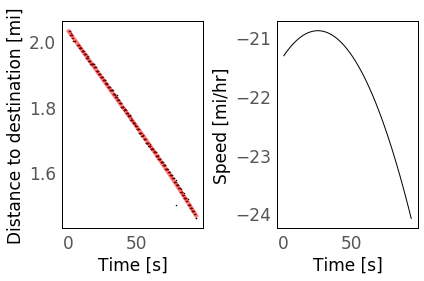

In [395]:
fig, (ax, bx) = plt.subplots(ncols=2)
ax.scatter(t_cleaned, d_cleaned, s=1)
ax.plot(t_cleaned, spl(t_cleaned), linewidth=4, alpha=.5, color='red')
ax.set_ylabel('Distance to destination [mi]')

bx.plot(t_cleaned, spl.derivative(1)(t_cleaned) * 3600.)
bx.set_ylabel('Speed [mi/hr]')

for a in ax, bx:
    a.set_xlabel('Time [s]')

fig.tight_layout()

In [250]:
# import time
# for oem in [0, 1, 2, 3]:
#     for psm in [6, 7, 13]:
#         desc = 'OEM={o} PSM={p}'.format(o=oems[oem], p=psms[psm])
#         config = '--psm {psm} --oem {oem}'.format(psm=psm, oem=oem)
#         try:
#             res = pytesseract.image_to_string(
#                 get_miles_subimage(images[0]), 
#                 config=config
#             )
#             print(desc)
#             print(res)
#         except pytesseract.TesseractError as e:
#             print('Failed:', desc, ':', e, '\n')

In [23]:
Y1, Y2 = Y

In [28]:
len(Y1), len(Y1[0])

(5423, 2)

In [29]:
Y1[0]

(1629432034.950457, (5, 0.33725490196078434))

In [55]:
axis_times = np.array([t for (t, (aid, aval)) in Y1])
axis_ids = np.array([aid for (t, (aid, aval)) in Y1])
axis_vals = np.array([aval for (t, (aid, aval)) in Y1])

In [59]:
axes_used = list(sorted(set(axis_ids)))
axes_used

[0, 5]

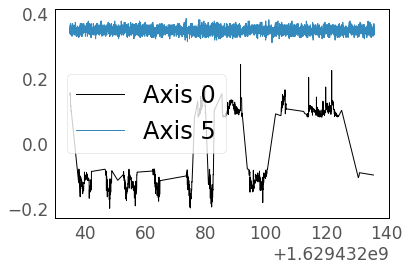

In [60]:
fig, ax = plt.subplots()
for i in axes_used:
    where = axis_ids == i
    ax.plot(axis_times[where], axis_vals[where], label='Axis %d' % i)
ax.legend()

In [61]:
#buttons
len(Y2)

0